# Neural Network Classification

### Dealing with the dataset

In [1]:
import torch
from torch import nn
import sklearn 
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Creating a sintetic dataset
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

# Turning the data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# Normalize the input data
X = (X - X.min()) /(X.max() - X.min())
y = (y - y.min()) /(y.max() - y.min())

# Spliting the dataset into traing and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a dataframe with the dataset
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'y': y})
display(df)

/home/matheus/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,X1,X2,y
0,0.866070,0.617581,1.0
1,0.148119,0.580399,1.0
2,0.119964,0.589917,1.0
3,0.320395,0.836902,1.0
4,0.717747,0.081304,0.0
...,...,...,...
995,0.623557,0.956327,0.0
996,0.042359,0.378080,0.0
997,0.442476,0.122521,1.0
998,0.826197,0.142728,0.0


X.shape: torch.Size([1000, 2])     y.shape: torch.Size([1000])

Values for one sample
X:  tensor([0.8661, 0.6176])
y:  [tensor(1.)]


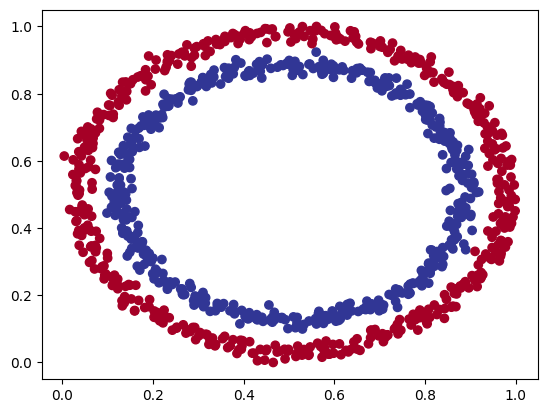

In [2]:
print(f'X.shape: {X.shape}     y.shape: {y.shape}\n')
print(f'Values for one sample\nX:  {X[0]}\ny:  {[y[0]]}')

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

### Building the model

In [3]:
# Checking if the GPU is availible to run the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device availible: ', device)


# Model
class CircleModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x  ->  layer_1  ->  layer_2  ->  output
        return self.layer_2(self.layer_1(x))


# Intanciating the model
model = CircleModel().to(device=device)
dict(model.state_dict())


device availible:  cpu


{'layer_1.weight': tensor([[-0.5567,  0.6901],
         [-0.4176,  0.1060],
         [ 0.5823, -0.6975],
         [ 0.4985,  0.4384],
         [-0.6724,  0.4482]]),
 'layer_1.bias': tensor([ 0.3840,  0.1068,  0.1807, -0.6669,  0.0369]),
 'layer_2.weight': tensor([[ 0.1647,  0.0898, -0.0471,  0.4133, -0.2604]]),
 'layer_2.bias': tensor([-0.3275])}

In [4]:
# Making predictions
with torch.inference_mode():
    untrained_preds = model(X_test.to(device))
print(f'\nFirst 5 predictions: \n{untrained_preds[:5].tolist()}')
print(f'\nFirst 5 labels:\n{y_test[:5].tolist()}')


First 5 predictions: 
[[-0.29096972942352295], [-0.220225527882576], [-0.43046948313713074], [-0.25163328647613525], [-0.3575320839881897]]

First 5 labels:
[1.0, 0.0, 1.0, 0.0, 1.0]


### Setting loss, optimizer and evaluation functions

In [5]:
# Loss function (sigmoid activation function builtin)
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Training the model

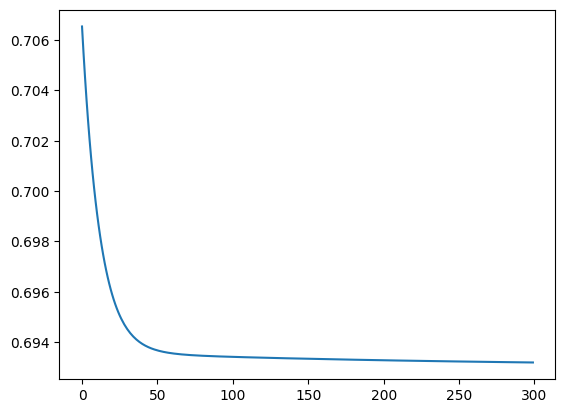

In [6]:
# Garant the reprodutibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Number of epochs the model will be trained
epochs = 300


# Training loop
ls = []
ac = []
for epoch in range(epochs):
    # Set the training mode
    model.train()
    
    # 1. Make the prediction with the forward method
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits  ->  pred prob  ->  pred labels

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    ls.append(float(loss))

    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

plt.plot(ls)